# Métodos de Aprendizaje no supervisado

In [1]:
import pandas as pd

df = pd.read_excel('../../res/tp4/acath.xlsx', sheet_name='acath')  # 3505 rows

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,0,73,132,268.0,1,1.0
1,0,68,85,120.0,1,1.0
2,0,54,45,NaN,1,0.0
3,1,58,86,245.0,0,0.0
4,1,56,7,269.0,0,0.0


In [2]:
import numpy as np

# Sanitize dataset
result_column = 'sigdz'
columns = ['sex', 'age', 'cad.dur', 'choleste', 'tvdlm']
numeric_columns = ['age', 'cad.dur', 'choleste']

# Replace numeric value for `sigdz` with logical value
df.replace({result_column: {1: 'T', 0: 'F'}}, inplace=True)
df.replace({'tvdlm': {1: 'T', 0: 'F'}}, inplace=True)
df.replace({'sex': {1: 'F', 0: 'M'}}, inplace=True)

# Replace NaN occurrences with mean
for column in numeric_columns:
    df.replace({column: {np.nan: int(df[column].mean())}}, inplace=True)

df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,M,73,132,268.0,T,T
1,M,68,85,120.0,T,T
2,M,54,45,229.0,T,F
3,F,58,86,245.0,F,F
4,F,56,7,269.0,F,F


## Regresión Logística

In [32]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.2)

In [33]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

def train_model(data, fields, result_var, params=None):
    model = LogisticRegression()
    model.fit(data[fields], data[result_var])
    return model


model = train_model(train, numeric_columns, result_column)

In [34]:
predicted = model.predict(test[numeric_columns])

Población completa


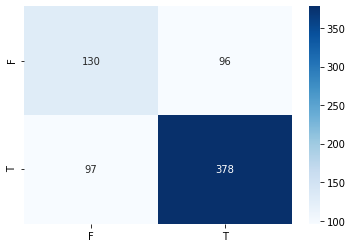

In [35]:
import seaborn as sns

def plot_confusion_matrix(data, result_var, predictions, title=None, ax=None):
    conf_mat = confusion_matrix(data[result_var], predictions)
    count_values = list(map(lambda x: sum(x), conf_mat))

    unique, counts = np.unique(np.array(data[result_var]), return_counts=True)
    count_labels = dict(zip(counts, unique))

    labels = []
    for value in count_values:
        labels.append(count_labels[value])

    if title is not None:
        print(title)

    if ax is None:
        sns.heatmap(conf_mat, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)
    else:
        sns.heatmap(conf_mat, ax=ax, annot=True, cmap='Blues', fmt='g', xticklabels=labels, yticklabels=labels)

plot_confusion_matrix(test, result_column, predicted, title='Población completa')

In [36]:
print(classification_report(test[result_column], predicted))

              precision    recall  f1-score   support

           F       0.57      0.58      0.57       226
           T       0.80      0.80      0.80       475

    accuracy                           0.72       701
   macro avg       0.69      0.69      0.69       701
weighted avg       0.72      0.72      0.72       701



### Regresión Logística por género

In [37]:
men = df[df.sex == 'M']
women = df[df.sex == 'F']

train_men, test_men = train_test_split(men, test_size=0.2)
train_women, test_women = train_test_split(women, test_size=0.2)

print(f'Hombres: {len(men)}\nMujeres: {len(women)}')

Hombres: 2405
Mujeres: 1099


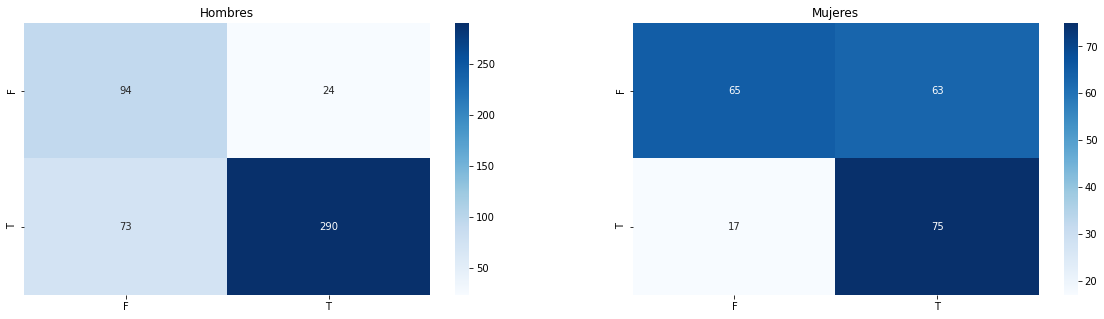

In [55]:
import matplotlib.pyplot as plt

model_men = train_model(train_men, numeric_columns, result_column)
model_women = train_model(train_women, numeric_columns, result_column)

predicted_men = model.predict(test_men[numeric_columns])
predicted_women = model.predict(test_women[numeric_columns])

tests = [test_men, test_women]
preds = [predicted_men, predicted_women]
titles = ['Hombres', 'Mujeres']

conf_mat_fig = plt.figure(figsize=(20,5))
i = 1
j = 2
k = 1
for test, pred, title in zip(tests, preds, titles):
    mat_ax = conf_mat_fig.add_subplot(i, j, k)
    mat_ax.set_title(title)
    plot_confusion_matrix(test, result_column, pred, ax=mat_ax)
    k += 1

In [60]:
for test, pred, title in zip(tests, preds, titles):
    print(title)
    print(classification_report(test[result_column], pred))

Hombres
              precision    recall  f1-score   support

           F       0.56      0.80      0.66       118
           T       0.92      0.80      0.86       363

    accuracy                           0.80       481
   macro avg       0.74      0.80      0.76       481
weighted avg       0.84      0.80      0.81       481

Mujeres
              precision    recall  f1-score   support

           F       0.79      0.51      0.62       128
           T       0.54      0.82      0.65        92

    accuracy                           0.64       220
   macro avg       0.67      0.66      0.64       220
weighted avg       0.69      0.64      0.63       220



## Agrupamiento Jerárquico

In [5]:
normalized_df = df.copy()
for column in numeric_columns:
    column_min = min(normalized_df[column])
    column_max = max(normalized_df[column])
    #print(f"{column_min} {column_max}")
    normalized_df[column] = normalized_df[column].apply(lambda x: (x - column_min) / (column_max - column_min))

normalized_df.head()

,sex,age,cad.dur,choleste,sigdz,tvdlm
0,M,0.861538,0.317308,0.436929,T,T
1,M,0.784615,0.204327,0.166362,T,T
2,M,0.569231,0.108173,0.365631,T,F
3,F,0.630769,0.206731,0.394881,F,F
4,F,0.600000,0.016827,0.438757,F,F


In [6]:
distance_matrix = np.zeros((len(normalized_df), len(normalized_df)))
num_norm_df = normalized_df[numeric_columns]
for i in range(len(normalized_df)):
    row_i = num_norm_df.iloc[i].to_numpy()
    for j in range(len(normalized_df)):
        if i >= j:
            continue
        row_j = num_norm_df.iloc[j].to_numpy()
        dist = np.linalg.norm(row_i - row_j)
        distance_matrix[i][j] = distance_matrix[j][i] = dist
    
    if i % 50 == 0:
        print(f"Processed {i} rows")

Processed 0 rows
Processed 50 rows
Processed 100 rows
Processed 150 rows
Processed 200 rows
Processed 250 rows
Processed 300 rows
Processed 350 rows
Processed 400 rows
Processed 450 rows
Processed 500 rows
Processed 550 rows
Processed 600 rows
Processed 650 rows
Processed 700 rows
Processed 750 rows
Processed 800 rows
Processed 850 rows
Processed 900 rows
Processed 950 rows
Processed 1000 rows
Processed 1050 rows
Processed 1100 rows
Processed 1150 rows
Processed 1200 rows
Processed 1250 rows
Processed 1300 rows
Processed 1350 rows
Processed 1400 rows
Processed 1450 rows
Processed 1500 rows
Processed 1550 rows
Processed 1600 rows
Processed 1650 rows
Processed 1700 rows
Processed 1750 rows
Processed 1800 rows
Processed 1850 rows
Processed 1900 rows
Processed 1950 rows
Processed 2000 rows
Processed 2050 rows
Processed 2100 rows
Processed 2150 rows
Processed 2200 rows
Processed 2250 rows
Processed 2300 rows
Processed 2350 rows
Processed 2400 rows
Processed 2450 rows
Processed 2500 rows
Pro

In [78]:
# [Nivel, Grupos]
# Grupos = [[p1, p2, p13], [p4], [p5, p9], ...] # array de sets

def get_basic_distance_between_groups(group_1, group_2, operation):
    min_dist = None
    for point_1_index in group_1:
        for point_2_index in group_2:
            dist = distance_matrix[point_1_index][point_2_index]
            if min_dist is None or eval(f"{dist} {operation} {min_dist}"):
                min_dist = dist
    return min_dist

def get_average_distance_between_groups(group_1, group_2):
    suma = 0
    for point_1_index in group_1:
        for point_2_index in group_2:
            suma += distance_matrix[point_1_index][point_2_index]
    return suma / (len(group_1) * len(group_2))

def get_centroid_distance_between_groups(group_1_index, group_2_index, centroids):
    return np.linalg.norm(centroids[group_1_index] - centroids[group_2_index])
    
def get_distance_between_groups(groups, group_1_index, group_2_index, mode, centroids=None):
    group_1 = groups[group_1_index]
    group_2 = groups[group_2_index]
    if mode == "min":
        return get_basic_distance_between_groups(group_1, group_2, "<")
    elif mode == "max":
        return get_basic_distance_between_groups(group_1, group_2, ">")
    elif mode == "avg":
        return get_average_distance_between_groups(group_1, group_2)
    elif mode == "ctr":
        return get_centroid_distance_between_groups(group_1_index, group_2_index, centroids)
    
    raise Exception("Invalid distance mode")

def hierarchical_clustering(mode, cluster_count):
    levels = [[]]
    for i in range(len(normalized_df)):
        levels[0].append(set([i]))
    
    centroids = None # Array of centroid coordinates for each group
    if mode == "ctr":
        centroids = []
        for i in range(len(num_norm_df)):
            centroids.append(num_norm_df.iloc[i].to_numpy())
    
    current_level = 0
    while len(levels[current_level]) > cluster_count:
        current_groups = levels[current_level]
        group_qty = len(levels[current_level])
        min_group_dist = None
        groups_to_merge = (None, None) # Indices
        for i in range(group_qty):

            for j in range(i + 1, group_qty):
                group_dist = get_distance_between_groups(current_groups, i, j, mode, centroids)
                if (min_group_dist is None) or (group_dist < min_group_dist):
                    groups_to_merge = (i, j)
                    min_group_dist = group_dist

        group_to_merge_1 = current_groups[groups_to_merge[0]]
        group_to_merge_2 = current_groups[groups_to_merge[1]]

        levels.append(current_groups.copy())
        new_group = set()
        new_group.update(group_to_merge_2)
        new_group.update(group_to_merge_1)
        levels[current_level + 1].append(new_group)
        del levels[current_level + 1][max(groups_to_merge)]
        del levels[current_level + 1][min(groups_to_merge)]
        
        if centroids is not None: # Push new group's centroid based on previous 2 centroids
            centroid = (centroids.pop(max(groups_to_merge)) + centroids.pop(min(groups_to_merge))) / 2
            centroids.append(centroid)

        current_level += 1
        
        if current_level % 50 == 0:
            print(f"Clusters joined: {current_level}")
        
    return levels

In [79]:
clusters_min_dist = hierarchical_clustering("avg", 2)

Clusters joined: 50
Clusters joined: 100
Clusters joined: 150
Clusters joined: 200
Clusters joined: 250
Clusters joined: 300
Clusters joined: 350
Clusters joined: 400
Clusters joined: 450
Clusters joined: 500
Clusters joined: 550
Clusters joined: 600
Clusters joined: 650
Clusters joined: 700
Clusters joined: 750
Clusters joined: 800
Clusters joined: 850
Clusters joined: 900
Clusters joined: 950
Clusters joined: 1000
Clusters joined: 1050
Clusters joined: 1100
Clusters joined: 1150
Clusters joined: 1200
Clusters joined: 1250
Clusters joined: 1300
Clusters joined: 1350
Clusters joined: 1400
Clusters joined: 1450
Clusters joined: 1500
Clusters joined: 1550
Clusters joined: 1600
Clusters joined: 1650
Clusters joined: 1700
Clusters joined: 1750
Clusters joined: 1800
Clusters joined: 1850
Clusters joined: 1900
Clusters joined: 1950
Clusters joined: 2000
Clusters joined: 2050
Clusters joined: 2100
Clusters joined: 2150
Clusters joined: 2200
Clusters joined: 2250
Clusters joined: 2300
Clusters

In [22]:
print(distance_matrix)

[[0.         0.30313061 0.36642118 ... 0.31337962 0.3051252  0.11862618]
 [0.30313061 0.         0.30877844 ... 0.26755869 0.43852606 0.21974721]
 [0.36642118 0.30877844 0.         ... 0.21605536 0.51948801 0.2741464 ]
 ...
 [0.31337962 0.26755869 0.21605536 ... 0.         0.56751626 0.26923077]
 [0.3051252  0.43852606 0.51948801 ... 0.56751626 0.         0.29847368]
 [0.11862618 0.21974721 0.2741464  ... 0.26923077 0.29847368 0.        ]]


In [85]:
len(clusters_min_dist)

3503

In [99]:
np.set_printoptions(linewidth=120)
print(clusters_min_dist[3499])

[{261}, {1178}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 140, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 169, 171, 172, 173, 174, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 209, 210, 211, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 

In [95]:
print(clusters_min_dist[3500])

[{261}, {1178}, {0, 2049, 2055, 3085, 3087, 2079, 32, 3104, 3107, 36, 3108, 37, 3113, 1068, 46, 48, 1073, 2098, 3126, 54, 1080, 59, 63, 2113, 2116, 2117, 3146, 74, 75, 1102, 85, 1110, 101, 102, 3176, 104, 3183, 112, 1139, 117, 1146, 123, 122, 3200, 137, 3210, 2185, 139, 2189, 141, 143, 138, 3217, 154, 3231, 160, 3233, 3240, 3241, 170, 168, 175, 1201, 179, 3254, 1208, 192, 194, 1222, 1230, 3281, 212, 213, 1238, 3287, 1240, 3293, 2272, 1250, 1254, 2278, 3304, 3302, 1257, 2285, 240, 2290, 3315, 2294, 1271, 3320, 2297, 1276, 3327, 1283, 3332, 262, 3335, 2315, 1295, 2321, 274, 1300, 281, 285, 296, 3369, 298, 299, 2347, 2349, 3370, 1336, 2361, 3386, 313, 317, 2366, 3394, 322, 326, 3400, 328, 330, 3406, 337, 3410, 3415, 3416, 2393, 3418, 347, 1371, 3420, 3424, 3432, 3434, 362, 364, 2413, 2414, 3442, 370, 2427, 379, 3455, 384, 387, 3461, 3463, 3466, 397, 3469, 3472, 2449, 400, 2451, 3474, 3473, 401, 3479, 3478, 2457, 2456, 1438, 3490, 1443, 420, 418, 421, 2475, 3502, 1454, 3503, 432, 436, 1465

In [96]:
print(clusters_min_dist[3501])

[{1178}, {1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 33, 34, 35, 38, 39, 40, 41, 42, 43, 44, 45, 47, 49, 50, 51, 52, 53, 55, 56, 57, 58, 60, 61, 62, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 76, 77, 78, 79, 80, 81, 82, 83, 84, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 103, 105, 106, 107, 108, 109, 110, 111, 113, 114, 115, 116, 118, 119, 120, 121, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 140, 142, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 155, 156, 157, 158, 159, 161, 162, 163, 164, 165, 166, 167, 169, 171, 172, 173, 174, 176, 177, 178, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 193, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251, 25

In [97]:
print(clusters_min_dist[3502])

[{1178}, {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 

## K-medias

In [74]:
def update_centroids(classes):
    for clase in classes.values():
        if clase["changed"]:
            clase["centroid"] = np.array(list(map(lambda x: num_norm_df.iloc[x], clase["indices"]))).mean(axis=0)
            clase["changed"] = False

K = 5
rng = np.random.default_rng()

classes = {i: {"indices": set(), "centroid": np.zeros(len(numeric_columns)), "changed": True} for i in range(1, K+1)}

random_classes = rng.integers(1, K+1, size=len(df))
for index, point_class in enumerate(random_classes):
    classes[point_class]["indices"].add(index)

while any(map(lambda x: x["changed"], classes.values())):
    update_centroids(classes)
    
    changes = []
    for clase, clase_value in classes.items():
        for point_index in clase_value["indices"]:
            point = num_norm_df.iloc[point_index]
            
            closest_class = (clase, np.linalg.norm(point - clase_value["centroid"]))
            
            # Find the closest cluster centroid
            for other_class, other_class_value in classes.items():
                if clase == other_class:
                    continue
                    
                other_centroid = other_class_value["centroid"]
                other_centroid_dist = np.linalg.norm(point - other_centroid)
                
                if other_centroid_dist < closest_class[1]:
                    closest_class = (other_class, other_centroid_dist)
            
            if closest_class[0] != clase:
                # Record belongs to another cluster, save for later update
                changes.append({"old_cluster": clase, "new_cluster": closest_class[0], "point_index": point_index})
                
    # Update clusters
    for change in changes:
        old_cluster = classes[change["old_cluster"]]
        new_cluster = classes[change["new_cluster"]]
        old_cluster["indices"].remove(change["point_index"])
        new_cluster["indices"].add(change["point_index"])
        old_cluster["changed"] = new_cluster["changed"] = True
        
    print(len(changes))
    


2786
667
288
334
377
316
213
127
128
43
36
27
18
17
20
32
38
25
18
8
5
2
1
0


In [75]:
print(classes)

{1: {'indices': {1, 5, 6, 8, 12, 13, 14, 16, 18, 21, 25, 26, 22, 28, 31, 34, 38, 39, 49, 50, 52, 53, 55, 56, 57, 64, 66, 67, 68, 71, 72, 79, 80, 86, 88, 90, 91, 94, 95, 96, 97, 99, 106, 108, 111, 114, 115, 116, 119, 120, 121, 125, 128, 130, 131, 132, 140, 141, 149, 150, 153, 163, 166, 171, 176, 180, 183, 189, 190, 191, 192, 205, 209, 212, 215, 219, 220, 223, 226, 228, 231, 234, 238, 243, 249, 252, 254, 256, 259, 260, 269, 270, 272, 276, 277, 279, 283, 284, 293, 301, 306, 307, 312, 320, 332, 334, 335, 342, 343, 345, 353, 355, 363, 368, 373, 375, 376, 378, 383, 395, 402, 404, 419, 429, 434, 438, 441, 446, 452, 463, 465, 467, 469, 473, 488, 496, 497, 499, 502, 509, 513, 515, 519, 522, 528, 540, 543, 558, 562, 565, 568, 580, 589, 592, 593, 594, 596, 597, 602, 605, 606, 608, 615, 617, 627, 638, 643, 645, 654, 669, 686, 690, 698, 719, 726, 731, 735, 742, 752, 754, 773, 784, 786, 797, 803, 810, 814, 822, 827, 833, 847, 861, 878, 882, 888, 907, 971, 973, 980, 981, 991, 996, 998, 1015, 1021, 10

In [77]:
num_norm_df.head(10)

,age,cad.dur,choleste
0,0.861538,0.317308,0.436929
1,0.784615,0.204327,0.166362
2,0.569231,0.108173,0.365631
3,0.630769,0.206731,0.394881
4,0.600000,0.016827,0.438757
5,0.723077,0.000000,0.365631
6,0.738462,0.182692,0.365631
7,0.369231,0.036058,0.398537
8,0.784615,0.072115,0.365631
9,0.538462,0.002404,0.365631
